# Семинар 5: Линейная регрессия, временные признаки и регуляризация

## Подготовка и загрузка данных


In [1]:
%matplotlib inline

In [2]:
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh import extract_features

In [7]:
DATA_PATH = "./jena_climate_2009_2016.csv"

In [8]:
columns = ["Date Time", "p (mbar)",
               "T (degC)", "Tpot (K)",
               "Tdew (degC)", "rh (%)",
               "VPmax (mbar)", "VPact (mbar)",
               "VPdef (mbar)", "sh (g/kg)",
               "H2OC (mmol/mol)", "rho (g/m**3)",
               "wv (m/s)", "max. wv (m/s)", "wd (deg)"]

In [9]:
def load_jena(path: str) -> pd.DataFrame:
    """
    Пытается загрузить датасет Jena Climate из CSV.
    """
    columns = ["Date Time", "p (mbar)",
               "T (degC)", "Tpot (K)",
               "Tdew (degC)", "rh (%)",
               "VPmax (mbar)", "VPact (mbar)",
               "VPdef (mbar)", "sh (g/kg)",
               "H2OC (mmol/mol)", "rho (g/m**3)",
               "wv (m/s)", "max. wv (m/s)", "wd (deg)"]
    
    if os.path.exists(path):
        df = pd.read_csv(path)
        # Убедимся, что все ожидаемые столбцы присутствуют
        missing_cols = [c for c in columns if c not in df.columns]
        if missing_cols:
            raise ValueError(f"В файле отсутствуют ожидаемые столбцы: {missing_cols}")

    # Преобразование времени и индекса
    df["Date Time"] = pd.to_datetime(df["Date Time"], format='%d.%m.%Y %H:%M:%S')
    # df["Date Time"] = pd.to_datetime(df["Date Time"])
    df = df.sort_values("Date Time").set_index("Date Time")
    # df = df.sort_values("Date Time")
    return df

In [10]:
df = load_jena(DATA_PATH)
dfh = df.resample("1h").mean().dropna()
print("Форма:", df.shape, "| Часовые средние:", dfh.shape)

Форма: (420551, 14) | Часовые средние: (70041, 14)


In [11]:
corr = np.corrcoef(df.values, rowvar=False)

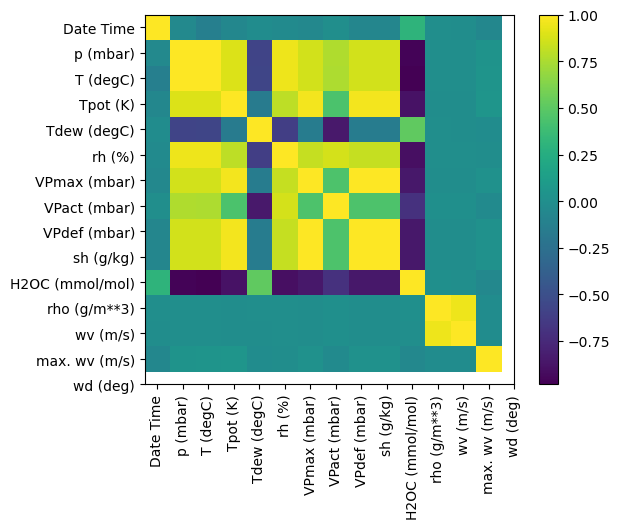

In [12]:
plt.imshow(corr)
_ = plt.xticks(ticks = np.arange(len(columns)), labels=columns, rotation=90)
_ = plt.yticks(ticks = np.arange(len(columns)), labels=columns)
plt.colorbar()
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
target = "T (degC)"
excluded = ["Date Time", "p (mbar)",
               "T (degC)", "Tpot (K)",
               "Tdew (degC)"]
features = [c for c in dfh.columns if (c not in excluded)]

In [19]:
month_feature = ["%04d-%02d" % (d.year, d.month) for d in dfh.index]

In [21]:
unique_months = np.unique(month_feature)

In [29]:
dfh['month_feature'] = month_feature

In [30]:
dfh.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),month_feature
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000,2009-01
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667,2009-01
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667,2009-01
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333,2009-01
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333,2009-01


In [22]:
unique_months

array(['2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06',
       '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12',
       '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
       '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', 

In [26]:
months_train, months_test = train_test_split(unique_months, test_size=0.3)

In [27]:
months_train

array(['2013-09', '2014-11', '2015-10', '2011-12', '2013-06', '2016-05',
       '2014-06', '2013-12', '2014-09', '2010-02', '2009-12', '2016-08',
       '2010-10', '2014-01', '2016-09', '2013-04', '2012-12', '2015-06',
       '2010-07', '2013-10', '2011-05', '2015-03', '2012-10', '2016-02',
       '2016-01', '2014-12', '2011-07', '2015-01', '2009-03', '2009-11',
       '2009-10', '2010-01', '2011-01', '2012-01', '2010-09', '2010-06',
       '2015-02', '2012-07', '2009-09', '2012-03', '2010-05', '2011-04',
       '2014-03', '2015-08', '2013-07', '2015-04', '2009-06', '2013-01',
       '2016-03', '2012-08', '2012-05', '2016-04', '2014-04', '2011-08',
       '2010-04', '2014-08', '2017-01', '2015-05', '2014-10', '2011-11',
       '2015-12', '2009-07', '2015-07', '2013-02', '2009-01', '2011-10',
       '2010-03'], dtype='<U7')

In [28]:
months_test

array(['2011-09', '2010-11', '2014-02', '2010-12', '2009-04', '2013-05',
       '2013-08', '2012-09', '2015-09', '2009-02', '2010-08', '2015-11',
       '2016-06', '2013-03', '2009-08', '2009-05', '2012-02', '2014-07',
       '2016-07', '2012-11', '2016-12', '2016-10', '2012-06', '2011-02',
       '2016-11', '2013-11', '2012-04', '2011-06', '2011-03', '2014-05'],
      dtype='<U7')

In [31]:
dfh_train = dfh[dfh.month_feature.isin(months_train)]

In [32]:
dfh_test = dfh[dfh.month_feature.isin(months_test)]

In [33]:
X_train, X_test = dfh_train[features], dfh_test[features]
y_train, y_test = dfh_train[target], dfh_test[target]

In [34]:
features

['rh (%)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'wv (m/s)',
 'max. wv (m/s)',
 'wd (deg)']

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
rf_model = RandomForestRegressor()

In [38]:
rf_model

RandomForestRegressor()

In [39]:
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [40]:
pred_train = rf_model.predict(X_train)

In [44]:
rmse_train = np.sqrt(np.sum(np.square(pred_train - y_train))/len(y_train))
rmse_train

0.004202379796625422

In [42]:
mae_train = mean_absolute_error(y_train, pred_train)
mse_train = mean_squared_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)
rmse_train = root_mean_squared_error(y_train, pred_train)

In [43]:
print("mae_train: %f" % mae_train)
print("mse_train: %f" % mse_train)
print("r2_train: %f" % r2_train)
print("rmse_train: %f" % rmse_train)

mae_train: 0.001893
mse_train: 0.000018
r2_train: 1.000000
rmse_train: 0.004202


In [45]:
pred_test = rf_model.predict(X_test)

In [46]:
mae_test = mean_absolute_error(y_test, pred_test)
mse_test = mean_squared_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)
rmse_test = root_mean_squared_error(y_test, pred_test)

In [47]:
print("mae_test: %f" % mae_test)
print("mse_test: %f" % mse_test)
print("r2_test: %f" % r2_test)
print("rmse_test: %f" % rmse_test)

mae_test: 0.006221
mse_test: 0.000911
r2_test: 0.999988
rmse_test: 0.030177


In [48]:
np.std(y_train)

8.264820403793786

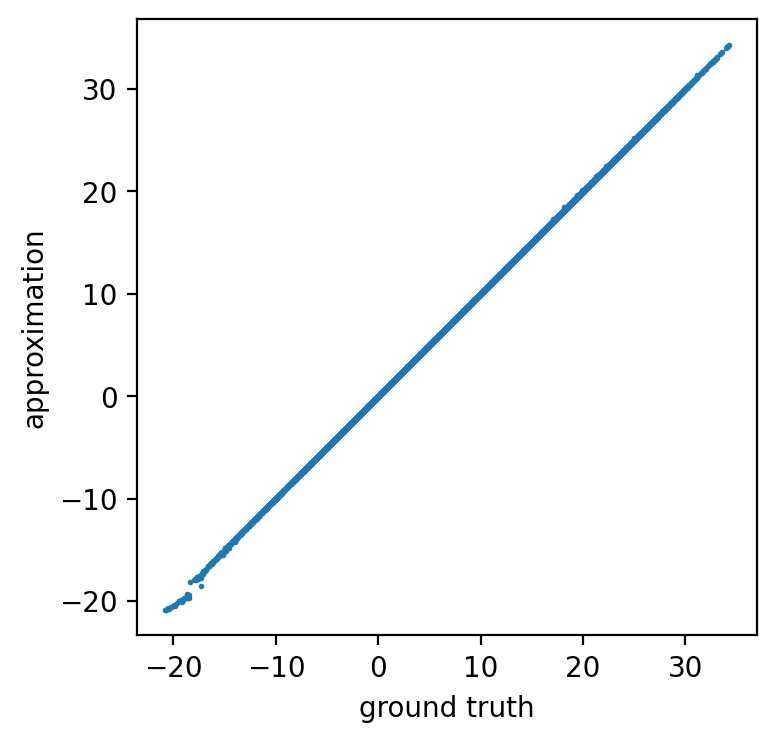

In [49]:
f = plt.figure(figsize=(4,4), dpi=200)
plt.scatter(y_test, pred_test, s=1)
plt.axis("equal")
# plt.xlim(-20, 50)
# plt.ylim(-20, 50)

plt.xlabel('ground truth')
plt.ylabel('approximation')
plt.show();

## Временные признаки + RandomForests


In [55]:
dfh = dfh.iloc[:5000, :]

In [56]:
ts = dfh[target].reset_index()
ts.columns = ["time", "value"]

In [57]:
ts.shape

(5000, 2)

In [59]:
ts.head()

,time,value
0,2009-01-01 00:00:00,-8.304000
1,2009-01-01 01:00:00,-8.065000
2,2009-01-01 02:00:00,-8.763333
3,2009-01-01 03:00:00,-8.896667
4,2009-01-01 04:00:00,-9.348333


In [60]:
df_lag, y_lag = make_forecasting_frame(ts["value"], kind="temp", max_timeshift=72, rolling_direction=1)

Rolling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.61it/s]


In [62]:
df_lag.head(100)

,id,time,value,kind
24383,"(id, 1)",0,-8.304000,temp
24385,"(id, 2)",0,-8.304000,temp
24386,"(id, 2)",1,-8.065000,temp
24388,"(id, 3)",0,-8.304000,temp
24389,"(id, 3)",1,-8.065000,temp
...,...,...,...,...
24491,"(id, 14)",4,-9.348333,temp
24492,"(id, 14)",5,-9.716667,temp
24493,"(id, 14)",6,-9.298333,temp
24494,"(id, 14)",7,-8.543333,temp


In [63]:
y_lag.shape

(4999,)

In [64]:
features_lag = extract_features(df_lag, column_id="id", column_sort="time", column_value="value")

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:36<00:00,  5.22s/it]


In [65]:
features_lag.shape

(4999, 783)

In [66]:
for f in features_lag.columns:
    f_array = features_lag[f].values
    print(np.all(np.isnan(f_array)))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [67]:
X = features_lag.dropna(axis=1)

In [68]:
X.shape

(4999, 218)

In [69]:
X = X.dropna(axis=0)

In [70]:
X.shape

(4999, 218)

In [71]:
y = y_lag.loc[X.index]

In [72]:
y.shape

(4999,)

In [74]:
weeks = [d.isocalendar().week for d in ts.time][1:]

In [75]:
X['week'] = weeks

In [76]:
y = pd.DataFrame(y, columns=['value'])

In [77]:
y.head()

,value
"(id, 1)",-8.065000
"(id, 2)",-8.763333
"(id, 3)",-8.896667
"(id, 4)",-9.348333
"(id, 5)",-9.716667


In [78]:
y['week'] = weeks

In [79]:
y.head()

,value,week
"(id, 1)",-8.065000,1
"(id, 2)",-8.763333,1
"(id, 3)",-8.896667,1
"(id, 4)",-9.348333,1
"(id, 5)",-9.716667,1


In [80]:
unique_weeks = np.unique(weeks)

In [81]:
unique_weeks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [82]:
weeks_train, weeks_test = train_test_split(unique_weeks, train_size=0.7)

In [83]:
weeks_train, weeks_test

(array([23, 28, 10,  4,  8, 11, 21, 26,  9,  7, 22, 25, 18, 30,  2, 27,  3,
        16,  6,  5,  1]),
 array([14, 12, 13, 29, 24, 31, 15, 17, 19, 20]))

In [84]:
X_train = X[X.week.isin(weeks_train)]
X_train.shape

(3455, 219)

In [85]:
X_test = X[X.week.isin(weeks_test)]
X_test.shape

(1544, 219)

In [86]:
y_train = y[y.week.isin(weeks_train)]
y_train.shape

(3455, 2)

In [87]:
y_test = y[y.week.isin(weeks_test)]
y_test.shape

(1544, 2)

In [89]:
model = RandomForestRegressor(n_jobs=6)
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

In [90]:
mae_train = mean_absolute_error(y_train, pred_train)
mse_train = mean_squared_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)
rmse_train = root_mean_squared_error(y_train, pred_train)

In [91]:
print("mae_train: %f" % mae_train)
print("mse_train: %f" % mse_train)
print("r2_train: %f" % r2_train)
print("rmse_train: %f" % rmse_train)

mae_train: 0.122857
mse_train: 0.050019
r2_train: 0.999413
rmse_train: 0.181128


In [92]:
mae_test = mean_absolute_error(y_test, pred_test)
mse_test = mean_squared_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)
rmse_test = root_mean_squared_error(y_test, pred_test)

In [93]:
print("mae_test: %f" % mae_test)
print("mse_test: %f" % mse_test)
print("r2_test: %f" % r2_test)
print("rmse_test: %f" % rmse_test)

mae_test: 1.938658
mse_test: 5.590067
r2_test: 0.845675
rmse_test: 2.335798


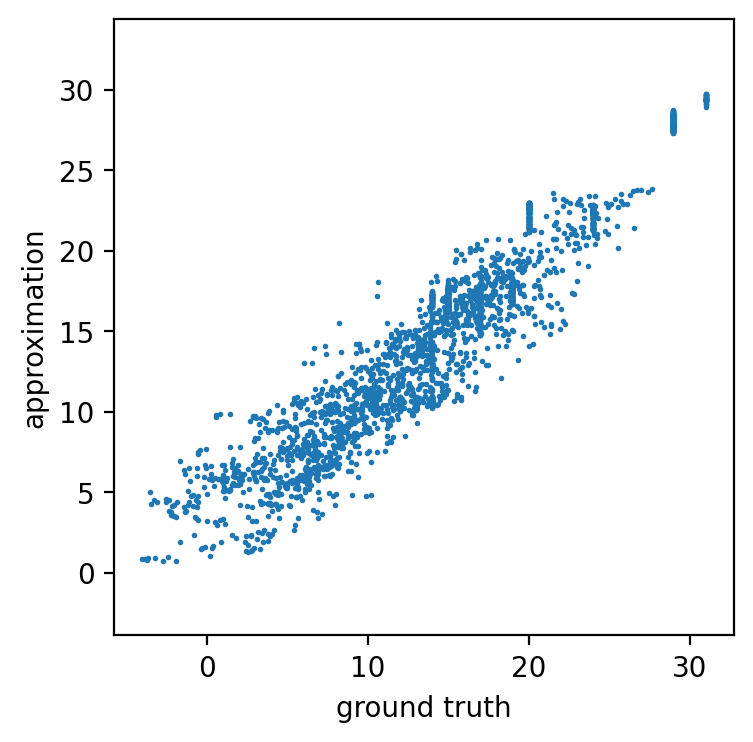

In [94]:
f = plt.figure(figsize=(4,4), dpi=200)
plt.scatter(y_test, pred_test, s=1)
plt.axis("equal")
# plt.xlim(-20, 50)
# plt.ylim(-20, 50)

plt.xlabel('ground truth')
plt.ylabel('approximation')
plt.show();